In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn import linear_model
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
sigorta=pd.read_csv('insurance.csv')
sigorta.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
sigorta.columns=['yas','cinsiyet','vki','cocuk','sigara','bolge','ucretler']
sigorta.head()

,yas,cinsiyet,vki,cocuk,sigara,bolge,ucretler
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [9]:
sigorta["kadin_mi"]= pd.get_dummies(sigorta.cinsiyet) ## , drop_first=True
sigorta["sigara_icer_mi"]=sigorta.sigara.replace({'yes':1, 'no':0})
sigorta[["kadin_mi","sigara_icer_mi"]].head()

,kadin_mi,sigara_icer_mi
0,1,1
1,0,0
2,0,0
3,0,0
4,0,0


In [10]:
y=sigorta["ucretler"]
x=sigorta[["kadin_mi","sigara_icer_mi"]]

In [11]:
lrm=linear_model.LinearRegression()
lrm.fit(x,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [12]:
print("Degiskenler: \n", lrm.coef_)
print("Sabit katsayi (bias): \n", lrm.intercept_)

Degiskenler: 
 [   65.37843464 23622.1345855 ]
Sabit katsayi (bias): 
 8400.657392079142


In [17]:
## Varsayım 1: Katsayılarda modelin doğrusallığı
## y= 1 + 2x1 + 3x1^2

df=pd.DataFrame()
df["x"]=np.arange(0,1000,1)
df["x_sq"]=df["x"]**2
df["y"]=1+ 2*df["x"]+ 3*df["x_sq"]
df.head()

,x,x_sq,y
0,0,0,1
1,1,1,6
2,2,4,17
3,3,9,34
4,4,16,57


In [18]:
lrm_ornek=linear_model.LinearRegression()
lrm_ornek.fit(df[["x","x_sq"]],df["y"])
tahmin=lrm_ornek.predict(df[["x","x_sq"]])

print("Degiskenler: \n", lrm_ornek.coef_)
print("Sabit katsayi (bias): \n", lrm_ornek.intercept_)

Degiskenler: 
 [2. 3.]
Sabit katsayi (bias): 
 0.9999999991850927


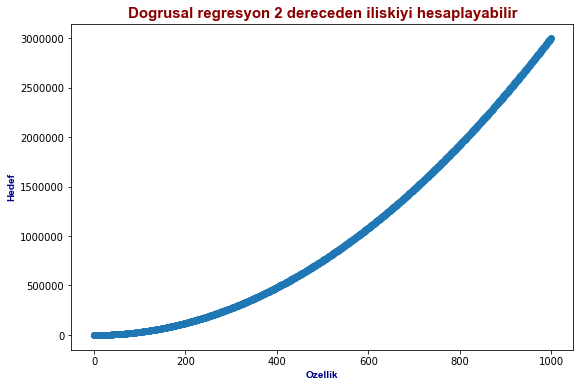

In [21]:
baslik_font = {'family': 'arial','color':  'darkred','weight': 'bold','size': 15 }
eksen_font = {'family': 'arial','color':  'darkblue','weight': 'bold','size': 10 }

plt.figure(figsize=(9,6))
plt.scatter(df["x"], tahmin)
plt.xlabel("Ozellik",fontdict=eksen_font)
plt.ylabel("Hedef",fontdict=eksen_font)
plt.title("Dogrusal regresyon 2 dereceden iliskiyi hesaplayabilir", fontdict=baslik_font)
plt.show()

In [22]:
### Varsayım 2: Hata terimi ortalamada sıfır olmalıdır
tahmin=lrm.predict(x)
hatalar=y-tahmin
print("Tibbi maliyetler modelinin ortalama hatasi: {:.15f}".format(np.mean(hatalar)))


Tibbi maliyetler modelinin ortalama hatasi: -0.000000000001548


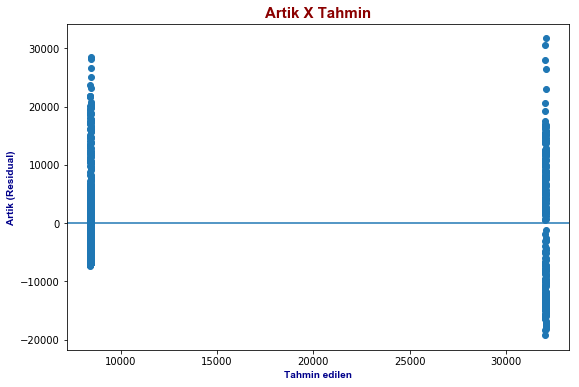

In [23]:
### Varsayım 3: homoscedasticity
plt.figure(figsize=(9,6))

plt.scatter(tahmin,hatalar)
plt.xlabel("Tahmin edilen", fontdict=eksen_font)
plt.ylabel("Artik (Residual)", fontdict=eksen_font)
plt.axhline(y=0)
plt.title("Artik X Tahmin", fontdict=baslik_font)
plt.show()

In [24]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats=bartlett(tahmin,hatalar)
lev_stats=levene(tahmin,hatalar)

print("Bartlett test değeri : {0:3g} ve p değeri : {1:.21f}".format(bart_stats[0], bart_stats[1]))
print("Levene test değeri   : {0:3g} ve p değeri : {1:.21f}".format(lev_stats[0], lev_stats[1]))

##Her iki testin p değerleri 0.05'ten düşüktür. 
##Dolayısıyla, test sonuçları null hipotezini reddeder, bu da hatalarımızın heteroscedastic olduğu anlamına gelir

Bartlett test değeri : 78.9785 ve p değeri : 0.000000000000000000628
Levene test değeri   : 6.87294 ve p değeri : 0.008800645507790269204


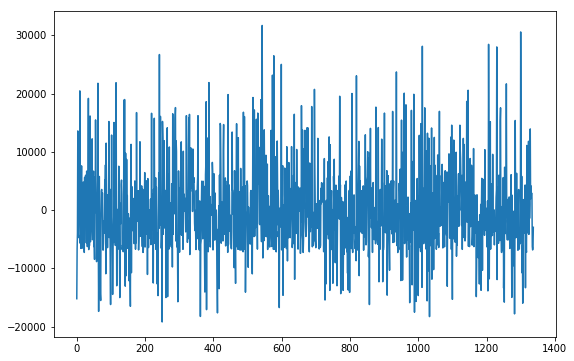

In [25]:
### Varsayım 5: hata terimleri birbiriyle ilişkisiz olmalıdır
plt.figure(figsize=(9,6))
plt.plot(hatalar)
plt.show()

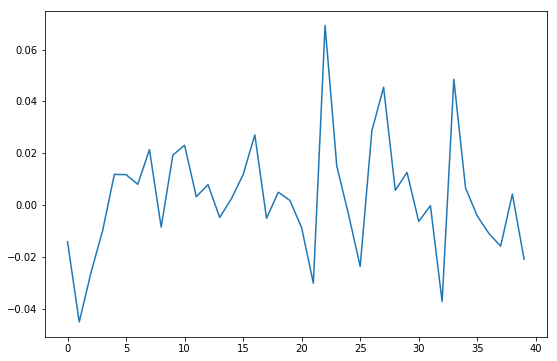

In [29]:
from statsmodels.tsa.stattools import acf
acf_data=acf(hatalar)
plt.figure(figsize=(9,6))
plt.plot(acf_data[1:])
plt.show()

##Tıbbi maliyetler modelimizin hataları arasındaki otokorelasyon gerçekten çok düşüktür (-0,06 ile 0,05 arasında).

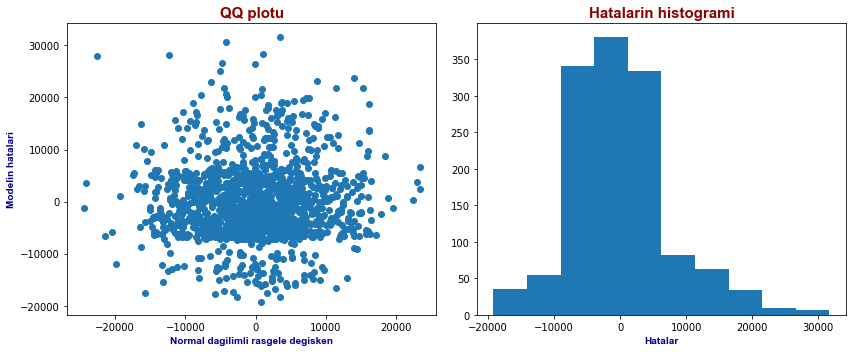

In [35]:
### Varsayım 6: özellikler hatalarla korele olmamalıdır

rand_nums=np.random.normal(np.mean(hatalar), np.std(hatalar),len(hatalar))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(rand_nums,hatalar)
plt.xlabel("Normal dagilimli rasgele degisken", fontdict=eksen_font)
plt.ylabel("Modelin hatalari",fontdict=eksen_font)
plt.title("QQ plotu", fontdict=baslik_font)

plt.subplot(1,2,2)
plt.hist(hatalar)
plt.xlabel("Hatalar",fontdict=eksen_font)
plt.title("Hatalarin histogrami", fontdict=baslik_font)
plt.tight_layout()
plt.show()

In [38]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats=jarque_bera(hatalar)
norm_stats=normaltest(hatalar)

print("Jarqua Bera test modeli: {0} ve p degeri: {1}".format(jb_stats[0], jb_stats[1]))
print("Normal test modeli: {0} ve p degeri: {1:.30f}".format(norm_stats[0], norm_stats[1]))

# Her iki testin p-değerleri, hatalarımızın normal olarak dağılmadığını gösterir.

Jarqua Bera test modeli: 211.8969328663115 ve p degeri: 0.0
Normal test modeli: 135.84195421490912 ve p degeri: 0.000000000000000000000000000003
